In [1]:
from requests import get, post
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import sympy as sp
from matplotlib import pyplot as plt
from pandas_datareader import data as web

# Carga de Dados
**Origem dos dados**

[Yahoo Finance](https://finance.yahoo.com/)

In [131]:
# Lista de ativos
assets = ['BBDC4.SA', 'VALE3.SA', 'ABEV3.SA', 'VVAR3.SA', 'PETR4.SA']
name_asset = ['Bradesco', 'ViaVarejo', 'Vale', 'Ambev', 'PetroBras']

In [236]:
# coletando dados e fatiando os ultimos 250 dias
df = pd.DataFrame()
for asset in assets:
    df[asset] = web.get_data_yahoo(asset)['Close']
df = df.iloc[-250:,:]
df.columns = name_asset
df.to_csv('./data_traditionaryMarkets.csv', index=False)

## Visualizando Dados

In [117]:
df = pd.read_csv('data_traditionaryMarkets.csv')
df

,Bradesco,ViaVarejo,Vale,Ambev,PetroBras
0,17.490910,4.97,35.189999,12.05,12.000000
1,16.063637,4.41,34.099998,11.51,11.500000
2,18.481817,5.01,37.639999,11.29,13.250000
3,19.863636,5.71,40.849998,11.65,14.320000
4,20.281818,5.70,42.000000,12.80,14.390000
...,...,...,...,...,...
245,26.600000,12.08,93.209999,15.54,23.520000
246,26.309999,12.11,91.059998,15.08,22.799999
247,26.040001,11.44,93.150002,14.80,22.820000
248,26.620001,12.04,92.440002,14.99,23.200001


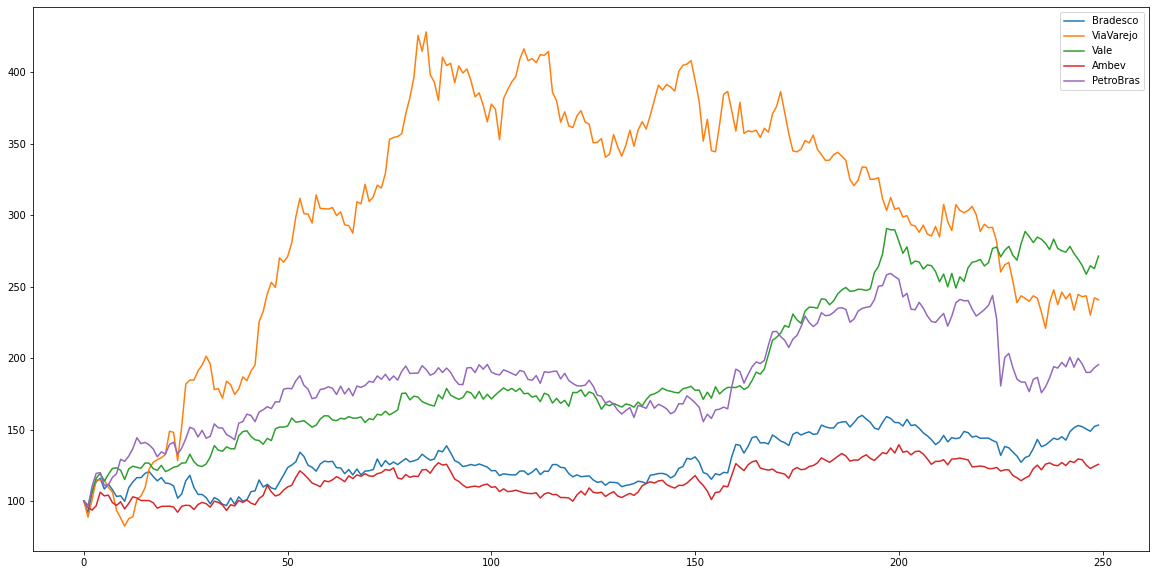

In [118]:
# Normaliza os dados na base 100
(df / df.iloc[0] * 100).plot(figsize=(20,10))
plt.show()

# Calculando Taxa de Retorno Simples, Logarítmicos e Volatilidade

**Retorno Simples:**
$$
r = \frac{P_i - P_f}{P_i} = \frac{P_f}{P_i} - 1
$$

**Retornos Logarítmicos**

$$
r = log(\frac{P_t}{P_{t-1}})
$$

In [94]:
def simple_return(asset):
    new_asset = (df[asset] / df[asset].shift(1)) - 1
    return new_asset

def log_return(asset):
    new_asset = (df[asset] / df[asset].shiftt(1)) - 1
    return new_asset

## Gráfico dos Retorno Simples Diários
- **map** aplica a função **simple_return** para cada **column** do dataframe **df**
- **pd.DataFrame** compila a transposta **array.T** do map desepacotado <strong>[*map]</strong> em um dataframe **df**
- **iloc** fatia o **df** retirando a primeira linha **[1:,:]**

In [95]:
assets_returns = pd.DataFrame([*map(simple_return, df)]).T.iloc[1:,:]
assets_returns

,Bradesco,ViaVarejo,Vale,Ambev,PetroBras
1,-0.081601,-0.112676,-0.030975,-0.044813,-0.041667
2,0.150538,0.136055,0.103812,-0.019114,0.152174
3,0.074766,0.139721,0.085282,0.031887,0.080755
4,0.021053,-0.001751,0.028152,0.098712,0.004888
5,-0.064993,0.000000,-0.045238,-0.024219,-0.075747
...,...,...,...,...,...
245,-0.005236,-0.006579,-0.016565,-0.003846,-0.020000
246,-0.010902,0.002483,-0.023066,-0.029601,-0.030612
247,-0.010262,-0.055326,0.022952,-0.018568,0.000877
248,0.022273,0.052448,-0.007622,0.012838,0.016652


In [96]:
# Normalização entre 1 e -1
def norm(df):
    normalize = MaxAbsScaler().fit_transform(df)
    return normalize

In [238]:
# calculando desvio padrão dos retornos nomalizados
std = norm(assets_returns).std() *2
x_hat = norm(assets_returns).mean()
print(f'{std*100:.2f}%')
print(f'{x_hat*100:.2f}%')

43.25%
2.14%


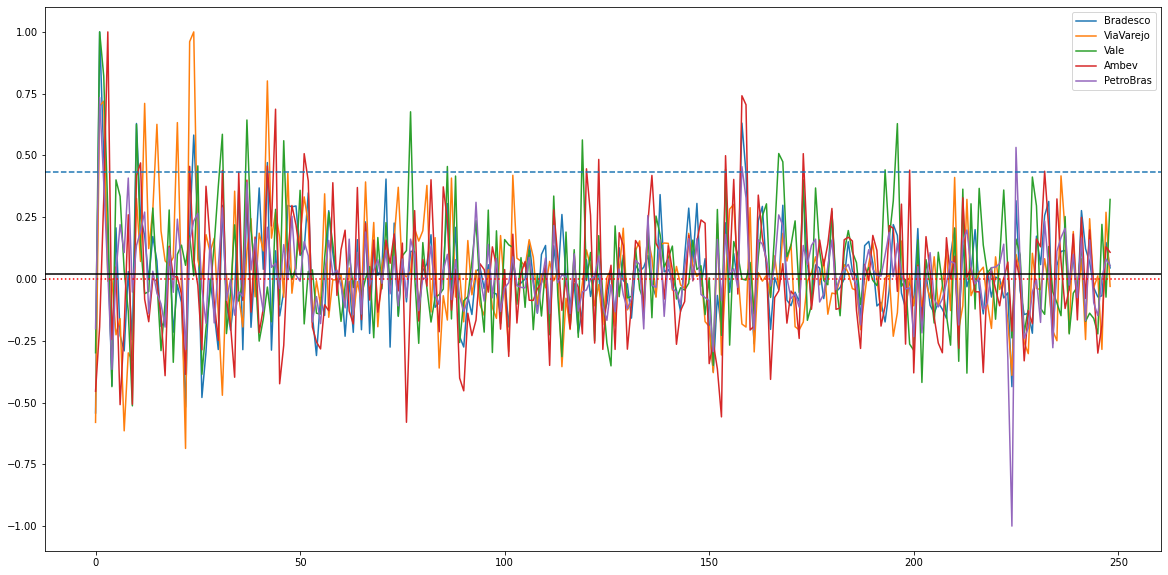

In [235]:
# Retornos diarios
pd.DataFrame(norm(assets_returns), columns=name_asset).plot(figsize=(20,10))
plt.axhline(y=std, linestyle='--')
plt.axhline(y=0, linestyle=':', color='#f00')
plt.axhline(y=x_hat, linestyle='-', color='#000')
plt.show()

### Calculando o Retorno Simples Diário e Anual

In [102]:
def mean_returns(asset):
    # media diaria
    x = assets_returns[asset].mean() * 100
    
    # media anual
    y = assets_returns[asset].mean() * 250 * 100
    
    # variacao diaria 
    z = assets_returns[asset].std() * 100

    # desvio padrao anual
    w = assets_returns[asset].std() * 250 ** 0.5 * 100
    return [x,y,z,w]

- **map** aplica a função **mean_returns** para cada *column* do dataframe **df**
- **pd.DataFrame** compila o map desempacotado <strong>[*map]</strong> em um dataframe **df**

In [103]:
col = ['Retorno Médio Diário', 'Retorno Médio Anual', 'Desvio Padrão Diário', 'Desvio Padrão Anual']
returns = pd.DataFrame(np.array([*map(mean_returns, assets_returns)]), index=assets_returns.columns,columns=col)
returns.style.format('{:.2f}%')

,Retorno Médio Diário,Retorno Médio Anual,Desvio Padrão Diário,Desvio Padrão Anual
Bradesco,0.22%,54.22%,3.04%,48.06%
ViaVarejo,0.45%,111.91%,4.40%,69.60%
Vale,0.43%,107.62%,2.41%,38.17%
Ambev,0.12%,30.51%,2.47%,38.99%
PetroBras,0.32%,81.19%,3.31%,52.34%


## Calculando Taxa de Retorno de um Portifólio

**Retorno do Portifólio**

```
O retorno do portifólio é dado pelo somatório do produto
dos retornos(sigma) pelo seu respectivo peso(w) na carteira 
```

$$
r =\begin{bmatrix}
    \sigma_1 \\
    \vdots \\
    \sigma_n
\end{bmatrix} 
\times \begin{bmatrix} w_1 \dots w_n \end{bmatrix}
$$

$$
r = \sum_{i=1}^{n} \sigma_i \times w_i
$$




In [104]:
# retornos anuais
annual_return = assets_returns.mean() * 250
annual_return

Bradesco     0.542221
ViaVarejo    1.119096
Vale         1.076200
Ambev        0.305063
PetroBras    0.811925
dtype: float64

### Simulação de Portifólios

In [171]:
# pesos de cada ativo na carteira
weights_A = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# Somatório do produto vetorial
portifolio_return_A = np.dot(annual_return, weights_A) * 100
print("Portifólio A")
print(str(round(portifolio_return_A, 2)) + '%')

Portifólio A
77.09%


In [239]:
# pesos de cada ativo na carteira
weights_B = np.array([0.2, 0.2, 0.2, 0., 0.4])

# Somatório do produto vetorial
portifolio_return_B = np.dot(annual_return, weights_B) * 100
print("Portifólio B")
print(str(round(portifolio_return_B, 2)) + '%')

Portifólio B
87.23%


In [240]:
# pesos de cada ativo na carteira
weights_C = np.array([0.3, 0.1, 0.1, 0.3, 0.2])

# Somatório do produto vetorial
portifolio_return_C = np.dot(annual_return, weights_C) * 100
print("Portifólio C")
print(str(round(portifolio_return_C, 2)) + '%')

Portifólio C
63.61%


# Índices de Mercado


*Índices compilam o comportamento geral do mercado são uma excelente base comparativa para entender a performance da ação analizada*


**Índices do EUA**

- DownJones: 30 maiores empresas e um dos mais antigos **igualmente ponderado**
- Standard&Poor's(SP500): 500 maiores empresas **universo diversificado e ponderado no valor de mercado**
- NASDAQ: maiores empresas de T.I. **ativos Agrupados**

**Índices Importantes**
- Reino Unido: **FTSE**
- Alemanha: **DAX30**
- Japão: **NIKKEI**
- China: **SSE**

**Índices Globais**
- **MSCI**: incluem mercados em desenvolvimento de todo mundo

## Carga do Dados

In [175]:
indices = ['^GSPC', '^IXIC', '^BVSP', '^GDAXI']
name_indices = ['S&P500', 'NASDAQ', 'Ibovespa', 'DAX30']

In [176]:
df = pd.DataFrame()
for i in indices:
    df[i] = web.get_data_yahoo(i)['Close']
df = df.iloc[-250:,:]
df.columns = name_indices
df.to_csv('./data_indices.csv', index=False)

## Visualizando Dados

In [177]:
df = pd.read_csv('data_indices.csv')
df

,S&P500,NASDAQ,Ibovespa,DAX30
0,2584.590088,7700.100098,73020.000000,9935.839844
1,2470.500000,7360.580078,70967.000000,9544.750000
2,2526.899902,7487.310059,72253.000000,9570.820312
3,2488.649902,7373.080078,69538.000000,9525.769531
4,2663.679932,7913.240234,74073.000000,10075.169922
...,...,...,...,...
245,3940.590088,13377.540039,114979.000000,14657.209961
246,3910.520020,13227.700195,113262.000000,14662.019531
247,3889.139893,12961.889648,112064.000000,14610.389648
248,3909.520020,12977.679688,113750.000000,14621.360352


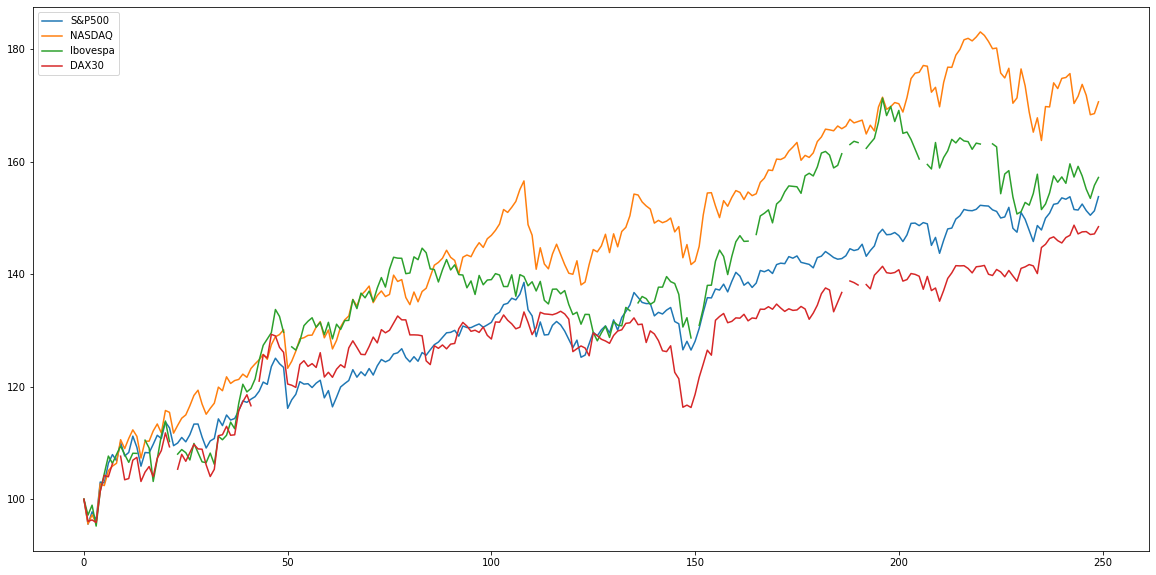

In [182]:
# Normaliza os dados na base 100
(df / df.iloc[0] * 100).plot(figsize=(20,10))
plt.show()

## Calculando retorno simples dos Índices

In [183]:
# Retornos diários
ind_returns = ((df / df.shift(1)) - 1).iloc[1:,:]
ind_returns

,S&P500,NASDAQ,Ibovespa,DAX30
1,-0.044142,-0.044093,-0.028116,-0.039362
2,0.022829,0.017217,0.018121,0.002731
3,-0.015137,-0.015256,-0.037576,-0.004707
4,0.070331,0.073261,0.065216,0.057675
5,-0.001603,-0.003283,0.030848,0.027943
...,...,...,...,...
245,0.007025,0.012281,-0.010695,0.002477
246,-0.007631,-0.011201,-0.014933,0.000328
247,-0.005467,-0.020095,-0.010577,-0.003521
248,0.005240,0.001218,0.015045,0.000751


In [184]:
# Retornos anuais
annual_ind_returns = ind_returns.mean() * 250
annual_ind_returns

S&P500      0.454992
NASDAQ      0.568586
Ibovespa    0.517688
DAX30       0.414040
dtype: float64

## Comparando performances de ações e indices
- Bradesco
- Vale
- Ambev
- Ibovespa

In [186]:
# Escolhendo ações do indice Ibovespa
parallel = assets[:3] + indices[2:3]
parallel

['BBDC4.SA', 'VALE3.SA', 'ABEV3.SA', '^BVSP']

In [187]:
compare = pd.DataFrame()
for i in parallel:
    compare[i] = web.get_data_yahoo(i)['Close']

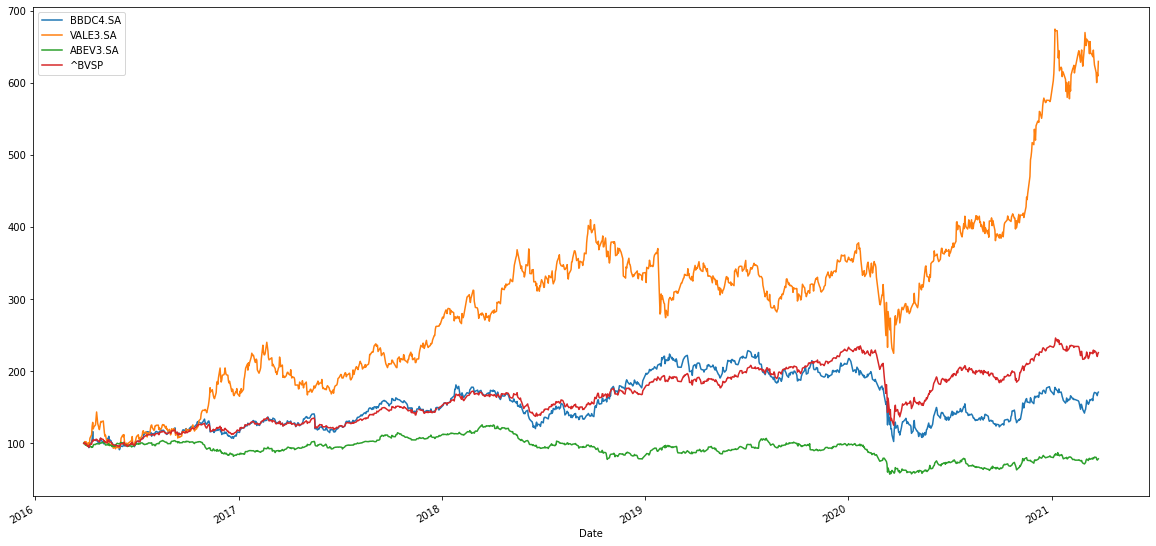

In [188]:
(compare / compare.iloc[0] * 100).plot(figsize=(20,10))
plt.show()

# Risco e Volatilidade 

**Variância**

```
Mede a distância entre os valores e a média.
var(x) = média dos  quadrados - quadrado da média
```
$$
var(x) = \frac{1}{n}\sum_{i=1}^{n}(x_i - \bar{x})^2
$$

$$
= \frac{1}{n}\sum_{i=1}^{n}x_i² - \bar{x}²
$$

**Desvio Padrão**
```
Mede a variação média
dp(x) = raiz quadrada da variância
```
$$
\sigma(x) = \sqrt{var(x)}
$$

## Calculando Volatilidade dos Ativos

In [191]:
def stats(asset):
    # variancia diaria
    var_d = assets_returns[asset].var() * 100
    
    # desvio padrao diario
    std_d = assets_returns[asset].std() * 100
    
    # variancia anual
    var_y = assets_returns[asset].var() * 100 * 250

    # variancia anual
    std_y = assets_returns[asset].std() * 250 ** 0.5 * 100

    return [var_d, var_y, std_d, std_y]

In [192]:
col = ['Variância Média Diária', 'Variância Média Anual', 'Desvio Padrão Diário', 'Desvio padrão Anual']
assets_var = pd.DataFrame(np.array([*map(stats, assets_returns)]), index=assets_returns.columns, columns=col)
assets_var.style.format('{:.5f}%')

,Variância Média Diária,Variância Média Anual,Desvio Padrão Diário,Desvio padrão Anual
Bradesco,0.09238%,23.09475%,3.03939%,48.05700%
ViaVarejo,0.19378%,48.44511%,4.40205%,69.60252%
Vale,0.05829%,14.57144%,2.41424%,38.17255%
Ambev,0.06080%,15.19964%,2.46574%,38.98672%
PetroBras,0.10957%,27.39198%,3.31010%,52.33735%


## Covariancia e Correlação

**Covariância**

```
Mede o grau de interdependência entre as variáveis
Cov(x,y) = média dos produtos - produto das médias
cov(x,y) >  0: x e y se movem na mesma direção
cov(x,y) <  0: x e y se movem em direções contrárias
cov(x,y) == 0: x e y são independentes
```
$$
cov(x, y) = \frac{1}{n}\sum_{i=1}^{n}(x_i - \bar{x})\cdot(y_i - \bar{y})
$$
$$
= \frac{1}{n}\sum_{i=1}^{n}x_i^2-\bar{x}^2
$$

**Coeficiente de Correlação**
```
Ajusta a cov(x,y) para um intervalo de [-1;1]
Corr(x,y) = {
        média dos produtos - produto das médias
        roduto das raiz quadrada da variância de x por y
}        
corr(x,y) = +ou- 1: o movimento de uma variável explica completamente o movimento da outra
corr(x,y) =  1: correlação positiva perfeita entre as duas variáveis.
corr(x,y) = -1: correlação negativa perfeita entre as duas variáveis.
corr(x,y) =  0: correlação nula
```

$$
corr(x,y) = \frac{cov(x,y)}{\sigma(x)\cdot \sigma(y)}
$$


**Matriz de Covariância**
$$
\begin{bmatrix}
var(x) && cov(x,y) \\
cov(x,y) && var(y)
\end{bmatrix}
$$

## Calculando Covariancia e Correlações

In [209]:
# covariancia anual
cov = assets_returns.cov() * 250
cov.style.background_gradient(cmap='coolwarm')

,Bradesco,ViaVarejo,Vale,Ambev,PetroBras
Bradesco,0.230948,0.138484,0.082068,0.110603,0.169575
ViaVarejo,0.138484,0.484451,0.040028,0.068268,0.130806
Vale,0.082068,0.040028,0.145714,0.033680,0.102596
Ambev,0.110603,0.068268,0.033680,0.151996,0.091551
PetroBras,0.169575,0.130806,0.102596,0.091551,0.273920


In [210]:
# correlação total
corr = assets_returns.corr()
corr.style.background_gradient(cmap='coolwarm')

,Bradesco,ViaVarejo,Vale,Ambev,PetroBras
Bradesco,1.000000,0.414016,0.447368,0.590327,0.674207
ViaVarejo,0.414016,1.000000,0.150657,0.251581,0.359079
Vale,0.447368,0.150657,1.000000,0.226309,0.513534
Ambev,0.590327,0.251581,0.226309,1.000000,0.448676
PetroBras,0.674207,0.359079,0.513534,0.448676,1.000000


# Risco de um Portifólio Simples

**A Variação(Risco) depende de:**
- *Desvio Padrão das ações*
- *Correlação entre as ações*

**Variação do Portifólio**
$$
\sigma1
$$
**Volatilidade do Portifólio**
$$
\sigma2
$$

In [220]:
# Peso das Ações
weights = np.full(5, 1/5)
weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [226]:
# Variação do Portifólio
pfolio_var = np.dot(weights.T, np.dot(assets_returns.cov() *250, weights))
print(f'{pfolio_var*100:.2f}%')

12.89%


In [228]:
# Volatilidade do Portifólio
pfolio_vol = np.dot(weights.T, np.dot(assets_returns.cov() *250, weights)) ** 0.5
print(f'{pfolio_vol*100:.2f}%')

35.90%


In [241]:
!sudo apt-get install texlive texlive-latex-extra pandoc

[sudo] senha para lucas: 
